In [17]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import s2sphere as s2
import matplotlib.pyplot as plt
import haversine
import pickle
from sklearn.model_selection import train_test_split

In [66]:
dset = 'harvey' # one of : sandy, all, harvey
n_bins = 6

In [67]:
def get_s2cell(lat, long, level):
    generator_obj = s2.CellId().from_lat_lng(s2.LatLng.from_degrees(lat, long)).parent(level)
    token = generator_obj.to_token()
    lat = generator_obj.to_lat_lng().lat().degrees
    lng = generator_obj.to_lat_lng().lng().degrees
    return (token, lat, lng)
get_s2cells = lambda df, level=14: pd.DataFrame(df.apply(lambda row: get_s2cell(row['lat_x'], row['lon_x'], level), axis=1).tolist(), columns=['token', 'slat', 'slng'])

norm = lambda df : la.norm(df.values, axis=1)



In [68]:
all_tweets = pd.read_pickle(f"../data/pickles/{dset}/cleanmoji.pkl")#.head(1000)
all_tweets['created_at_date'] = pd.to_datetime(all_tweets['created_at'], infer_datetime_format=True)
all_tweets = all_tweets.merge(get_s2cells(all_tweets), left_index=True, right_index=True)
all_tweets.set_index('created_at_date', inplace=True)
plot = all_tweets.resample('1H').mean()[['slat', 'slng', 'Sent_1']]
track = pd.read_pickle(f"../data/pickles/{dset}/track.pkl")
track['TIME_'] = track['TIME_'].dt.tz_localize("UTC")
track = track[['TIME_', 'LAT', 'LON', 'INTENSITY']]#.set_index("TIME_")
us_tweets = all_tweets[all_tweets['cc'] == "US"]
all_tweets['cc'].unique(), all_tweets.columns


(array(['VE', 'AW', 'US', 'DO', 'BQ', 'CO', 'HN', 'MX', 'IR', 'GB', 'PE'],
       dtype=object),
 Index(['full_text', 'created_at', 'id', 'lon_x', 'lat_x', 'lat_y', 'lon_y',
        'name', 'admin1', 'admin2', 'cc', 'Text', 'Top5%', 'Emoji_1', 'Emoji_2',
        'Emoji_3', 'Emoji_4', 'Emoji_5', 'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4',
        'Pct_5', 'Sent_1', 'Sent_2', 'Sent_3', 'Sent_4', 'Sent_5', 'token',
        'slat', 'slng'],
       dtype='object'))

In [69]:
sandy_tweets = pd.merge_asof(all_tweets.sort_index().reset_index(), track, left_on='created_at_date', right_on='TIME_', direction='nearest')
sandy_tweets.shape



(5609, 36)

In [70]:
train = sandy_tweets[['created_at_date', 'full_text', 'LAT', 'LON', 'lat_x', 'lon_x'] + [f'Sent_{i+1}' for i in range(5)]]
train['dist'] = haversine.haversine_vector(train[['lat_x', 'lon_x']].values, train[['LAT', 'LON']].values, unit='km')

In [71]:
train = train.rename({
    'created_at_date' : 'date',
    'full_text' : 'text',
    'LAT' : 'hlat',
    'LON' : 'hlon',
    'lat_x' : 'tlat',
    'lon_x' : 'tlon',
    'Sent_1' : 'sent',
}, axis='columns')[['date', 'text', 'hlat', 'hlon', 'tlat', 'tlon', 'sent', 'dist']]

<AxesSubplot:>

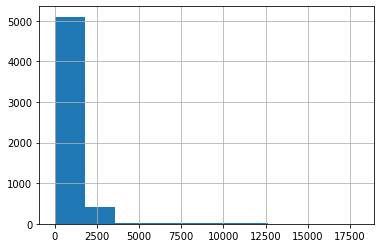

In [72]:
train['dist'].hist()

In [73]:

train['label'], dists = pd.cut(train['dist'], bins=n_bins, labels=[i for i in range(n_bins)],retbins=True, precision=1)
dists

array([  -18.02469903,  3004.11650436,  6008.23300873,  9012.34951309,
       12016.46601746, 15020.58252182, 18024.69902618])

In [74]:
train.to_pickle(f"../data/pickles/{dset}/train_{n_bins}.pkl", protocol=4)

In [75]:
train.head()

,date,text,hlat,hlon,tlat,tlon,sent,dist,label
0,2017-08-19 02:40:43+00:00,#Harvey continues westward over the eastern Ca...,13.4496,-64.8502,13.7000,-64.1000,0.521,85.735200,0
1,2017-08-19 12:20:09+00:00,⒍ Inapa\n⒎ España\n⒏ Yunesky Maya\n⒐ Samaná\n⒑...,13.7000,-67.5000,18.4867,-69.9405,0.351,592.647915,0
2,2017-08-19 12:40:09+00:00,⒍ #LLWS\n⒎ España\n⒏ #Harvey\n⒐ Cambrils\n⒑ #P...,13.7000,-67.5000,18.4867,-69.9405,0.657,592.647915,0
3,2017-08-19 13:00:09+00:00,⒍ Inapa\n⒎ España\n⒏ #Harvey\n⒐ Cambrils\n⒑ #P...,13.7000,-67.5000,18.4867,-69.9405,0.657,592.647915,0
4,2017-08-19 15:00:49+00:00,#Harvey still a tropical storm but less organi...,13.7496,-68.3502,13.9000,-68.1000,-0.173,31.772573,0


In [76]:
texts = train['text'].tolist()
info = [{'label' : label} for label in train['label']]
dflen = train.shape[0]
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(texts, info, range(dflen), test_size=0.33, random_state=42)


otherdset = 'sandy' if dset == 'harvey' else 'harvey'
test = pd.read_pickle(f"../data/pickles/{otherdset}/train_{n_bins}.pkl",)[:2000]
ttexts = test['text'].tolist()
tinfo = [{'label' : label} for label in test['label']]
tdflen = test.shape[0]

val_ind = i_test
test_ind = (dflen  + np.array(range(tdflen))).tolist()
train_ind = i_train

train_data =  { 'info': info + tinfo,
                'texts': texts + ttexts,
                'train_ind': train_ind,
                'test_ind': test_ind,
                'val_ind': val_ind,
                }

with open(f"../data/pickles/{dset}/trainloader_{n_bins}.pkl", 'wb') as handle:
    pickle.dump(train_data, handle, protocol=4)


In [77]:
# np.array(train_data['info'])[train_data['test_ind']]